<a href="https://colab.research.google.com/github/semmatoninn/CHE1148_MOFs_AtomicWizards/blob/main/MOFs_E3GNN__AtomicWizards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install ase torch torch_geometric torch_scatter torch_sparse torch_cluster -q

Before we begin lets install the proper packages we will need for GNN

1. Select T4 GPU
2. Comment in 4 install cells below
3. Once installed restart runtime and run the import cell

In [1]:
#!pip uninstall -y torch torchvision torchaudio
#!pip install torch==2.2.2 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Found existing installation: torch 2.10.0+cu128
Uninstalling torch-2.10.0+cu128:
  Successfully uninstalled torch-2.10.0+cu128
Found existing installation: torchvision 0.25.0+cu128
Uninstalling torchvision-0.25.0+cu128:
  Successfully uninstalled torchvision-0.25.0+cu128
Found existing installation: torchaudio 2.10.0+cu128
Uninstalling torchaudio-2.10.0+cu128:
  Successfully uninstalled torchaudio-2.10.0+cu128
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.2/757.2 MB 779.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 121.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv \
#-f https://data.pyg.org/whl/torch-2.2.2+cu121.html

#!pip install torch_geometric

Looking in links: https://data.pyg.org/whl/torch-2.2.2+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 117.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 132.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 946.2/946.2 kB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.6 MB/s eta 0:00:00


In [3]:
#import torch
#import torch_geometric

#print(torch.__version__)
#print(torch.version.cuda)
#print("PyG installed successfully!")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

2.2.2+cu121
12.1
PyG installed successfully!


In [4]:
#!pip install -q ase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.4 MB/s eta 0:00:00


In [1]:
#once installed restart runtime

import torch
import torch_geometric
import torch_scatter
import torch_sparse
import torch_cluster
import ase

print("Everything installed correctly!")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

Everything installed correctly!


In [2]:
#%cd /content/CHE1148_MOFs_AtomicWizards
#!ls

In [3]:
!git clone https://github.com/semmatoninn/CHE1148_MOFs_AtomicWizards/

Cloning into 'CHE1148_MOFs_AtomicWizards'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 22 (delta 7), reused 6 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 1.43 MiB | 6.09 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [4]:
!ls

CHE1148_MOFs_AtomicWizards  sample_data


In [5]:
import os
print(os.listdir('CHE1148_MOFs_AtomicWizards/'))

['MOFs_E3GNN__AtomicWizards.ipynb', 'mof_cif_194.zip', 'README.md', '.git', 'CO2_labels_per_MOF.csv']


In [6]:
#!unzip -q mof_cif_194.zip

In [7]:
#read the CO2 labels .csv file
import pandas as pd
df = pd.read_csv('CHE1148_MOFs_AtomicWizards/CO2_labels_per_MOF.csv')
df

,mof_name,mof_type,nco2_max,eads_min,eads_mean,n_configs
0,ADOBEB_charged,pristine,1,-0.146386,-0.030648,699
1,AJAKON,pristine,1,-0.218210,-0.088205,717
2,ANUGEW_deen_33,functionalized,1,-0.272465,0.020770,253
3,AQUCOG_0.11_0_deen_11,functionalized,1,-0.240284,-0.164271,449
4,AQUCOG_0.11_0_dmen_5.5,functionalized,1,-0.151717,-0.075495,286
...,...,...,...,...,...,...
189,ja506357n_si_002_0.12_0,defective,1,-0.323977,-0.188934,866
190,ja5b02897_si_003_0.08_0_en_12,functionalized,1,0.557638,0.664121,668
191,jz4002345_si_002,pristine,1,-0.261281,-0.187379,268
192,jz4002345_si_002_0.08_0,defective,1,-0.240357,-0.169550,508


In [8]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())

# Get a concise summary of the DataFrame, including data types
print("\nDataFrame Info:")
df.info()

Missing values per column:
mof_name     0
mof_type     0
nco2_max     0
eads_min     0
eads_mean    0
n_configs    0
dtype: int64

Number of duplicate rows:
0

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mof_name   194 non-null    object 
 1   mof_type   194 non-null    object 
 2   nco2_max   194 non-null    int64  
 3   eads_min   194 non-null    float64
 4   eads_mean  194 non-null    float64
 5   n_configs  194 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 9.2+ KB


In [9]:
from sklearn.model_selection import train_test_split

print("train_test_split imported successfully.")

train_test_split imported successfully.


In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

print(f"Shape of training set: {df_train.shape}")
print(f"Shape of testing set: {df_test.shape}")

Shape of training set: (155, 6)
Shape of testing set: (39, 6)


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Matplotlib and Seaborn imported successfully.")

Matplotlib and Seaborn imported successfully.


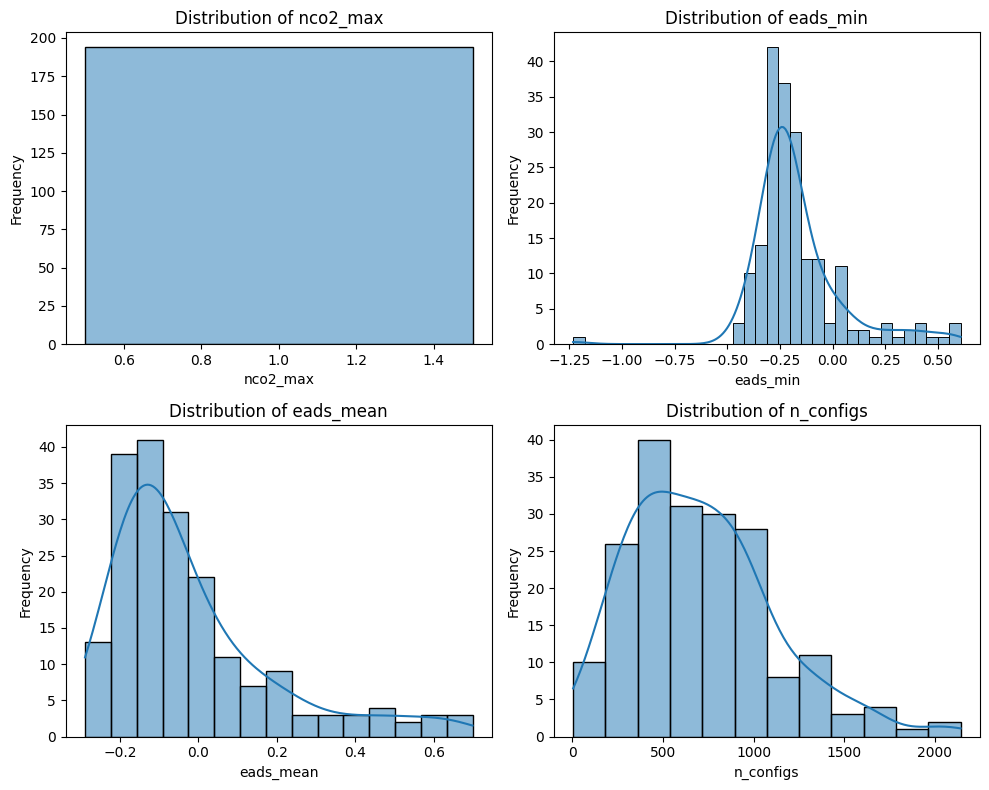

In [13]:
numerical_cols = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(10, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1) # Adjust subplot grid based on number of numerical columns
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()